In [189]:
import pandas as pd
import numpy as np
import fredapi as fa
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Enhanced Data Sourcing from FRED API with additional series
def fetch_fred_data(start_date='2000-01-01', end_date=datetime.today().strftime('%Y-%m-%d'), api_key=None):
    """Fetch Treasury yield data and additional economic indicators from FRED using the API."""
    # Get API key from environment variable if not provided
    if api_key is None:
        api_key = os.environ.get('FRED_API_KEY')
        if api_key is None:
            raise ValueError("FRED API key must be provided either directly or via FRED_API_KEY environment variable")
    
    # Initialize FRED API client
    fred = fa.Fred(api_key=api_key)
    
    # Define series to fetch
    series_dict = {
        # Original series
        'DGS3': '3_year_yield',
        'DGS5': '5_year_yield',
        'DGS7': '7_year_yield',
        'DGS10': '10_year_yield',
        'DGS20': '20_year_yield',
        'CPIAUCSL': 'cpi',
        'FEDFUNDS': 'fed_funds_rate',
        'VIXCLS': 'vix',
        
        # New series
        'DGS2': '2_year_yield',
        'CPILFESL': 'core_cpi',
        'WALCL': 'fed_assets',
        'DTWEXBGS': 'usd_index',
        'GDP': 'gdp'  # For other calculations
    }
    
    # Initialize dataframe to store results
    all_data = {}
    
    # Fetch each series
    for series_id, series_name in series_dict.items():
        print(f"Fetching {series_name} data...")
        series_data = fred.get_series(series_id, start_date, end_date)
        all_data[series_name] = series_data
    
    # Combine all series into a single dataframe
    df = pd.DataFrame(all_data)
    
    # Calculate 2Y-10Y spread and inversion flag
    if '2_year_yield' in df.columns and '10_year_yield' in df.columns:
        df['spread_2y_10y'] = df['10_year_yield'] - df['2_year_yield']
        df['yield_curve_inverted'] = (df['spread_2y_10y'] < 0).astype(int)
    
    # Forward fill missing values for better time series continuity
    df = df.ffill()
    
    print(f"Data fetched successfully. Shape: {df.shape}")
    return df

# 2. Enhanced Feature Engineering
def create_features(df, lags=[1, 5, 20]):
    """Generate lagged yields, term spreads, and rolling metrics for all indicators."""
    df_features = df.copy()
    
    # Yield and indicator columns
    yield_cols = ['2_year_yield', '3_year_yield', '5_year_yield', '7_year_yield', '10_year_yield', '20_year_yield']
    macro_cols = ['fed_funds_rate', 'core_cpi', 'fed_assets', 'usd_index']
    
    # All columns to process
    all_cols = yield_cols + macro_cols + ['spread_2y_10y']
    
    # 1. Create lagged features for all columns
    for col in all_cols:
        if col in df_features.columns:  # Check if column exists
            for lag in lags:
                df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag)
    
    # 2. Create change features (1-day, 5-day, 20-day changes)
    for col in all_cols:
        if col in df_features.columns:
            df_features[f'{col}_1d_chg'] = df_features[col].diff(1)
            df_features[f'{col}_5d_chg'] = df_features[col].diff(5)
            df_features[f'{col}_20d_chg'] = df_features[col].diff(20)
    
    # 3. Create rolling metrics (5-day and 30-day) for all columns
    for col in all_cols:
        if col in df_features.columns:
            df_features[f'{col}_ma5'] = df_features[col].rolling(window=5).mean()
            df_features[f'{col}_ma30'] = df_features[col].rolling(window=30).mean()
            df_features[f'{col}_vol5'] = df_features[col].rolling(window=5).std()
            df_features[f'{col}_vol30'] = df_features[col].rolling(window=30).std()
    
    # 4. Calculate Fed Assets YoY change
    if 'fed_assets' in df_features.columns:
        df_features['fed_assets_yoy'] = df_features['fed_assets'].pct_change(252) * 100
    
    # 5. Maintain original term spreads
    df_features['spread_10y_3y'] = df_features['10_year_yield'] - df_features['3_year_yield']
    df_features['spread_20y_10y'] = df_features['20_year_yield'] - df_features['10_year_yield']
    df_features['spread_20y_3y'] = df_features['20_year_yield'] - df_features['3_year_yield']
    
    # Drop rows with NaN values due to lagging/rolling
    df_features = df_features.dropna()
    return df_features

# 3. Prepare Data for Modeling with Train/Test Split
def prepare_data(df_features, target_col='10_year_yield', test_size=0.2):
    """Split features and target, create train/test sets using an 80/20 time-series split."""
    # Target: Next day's 10-year yield
    df_features['target'] = df_features[target_col].shift(-1)
    df_features = df_features.dropna()
    
    # Features: All columns except target and original macro inputs
    exclude_cols = ['target', 'cpi', 'vix', 'gdp']
    feature_cols = [col for col in df_features.columns if col not in exclude_cols]
    
    # Create 80/20 time-series split
    split_idx = int(len(df_features) * (1 - test_size))
    
    # Train set
    X_train = df_features[feature_cols].iloc[:split_idx]
    y_train = df_features['target'].iloc[:split_idx]
    
    # Test set
    X_test = df_features[feature_cols].iloc[split_idx:]
    y_test = df_features['target'].iloc[split_idx:]
    
    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, feature_cols

# 4. Train Voting Ensemble Model (XGBoost + RandomForest)
def train_ensemble_model(X_train, y_train, param_grid=None):
    """Train a VotingRegressor with XGBoost and RandomForest models."""
    # XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # RandomForest model
    rf_model = RandomForestRegressor(random_state=42)
    
    # Default parameter grid for XGBoost if none provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Grid search for XGBoost hyperparameter tuning
    grid_search = GridSearchCV(
        xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    # Best XGBoost model
    best_xgb_model = grid_search.best_estimator_
    print(f"Best XGBoost parameters: {grid_search.best_params_}")
    
    # Train RandomForest with default parameters
    rf_model.fit(X_train, y_train)
    
    # Create and train VotingRegressor with weights 0.8/0.2
    ensemble = VotingRegressor(
        estimators=[('xgb', best_xgb_model), ('rf', rf_model)],
        weights=[0.8, 0.2]
    )
    ensemble.fit(X_train, y_train)
    
    return ensemble, grid_search

# 5. Model Evaluation on Test Set
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate model performance with RMSE, MAE, and directional accuracy on train and test sets."""
    # Train set predictions
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    
    # Directional accuracy - training
    actual_diff_train = np.sign(y_train - y_train.shift(1).fillna(0))
    pred_diff_train = np.sign(pd.Series(train_preds, index=y_train.index) - y_train.shift(1).fillna(0))
    train_dir_acc = np.mean(actual_diff_train == pred_diff_train) * 100
    
    # Test set predictions
    test_preds = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    # Directional accuracy - test
    actual_diff_test = np.sign(y_test - y_test.shift(1).fillna(0))
    pred_diff_test = np.sign(pd.Series(test_preds, index=y_test.index) - y_test.shift(1).fillna(0))
    test_dir_acc = np.mean(actual_diff_test == pred_diff_test) * 100
    
    # Print metrics
    print("\n--- Training Set Performance ---")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"MAE: {train_mae:.4f}")
    print(f"Directional Accuracy: {train_dir_acc:.2f}%")
    
    print("\n--- Test Set Performance ---")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"Directional Accuracy: {test_dir_acc:.2f}%")
    
    # Plot predictions vs actual for test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual 10Y Yield', color='blue')
    plt.plot(y_test.index, test_preds, label='Predicted 10Y Yield', color='red', linestyle='--')
    plt.title('Test Set: Actual vs Predicted 10-Year Treasury Yield')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig('yield_predictions.png')
    plt.close()
    
    # Feature importance plot (using XGBoost model)
    xgb_model = model.named_estimators_['xgb']
    feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    plt.figure(figsize=(12, 8))
    plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance])
    plt.title('Top 15 Feature Importance')
    plt.xlabel('Gain')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    return {
        'train_rmse': train_rmse, 
        'train_mae': train_mae, 
        'train_dir_acc': train_dir_acc,
        'test_rmse': test_rmse, 
        'test_mae': test_mae, 
        'test_dir_acc': test_dir_acc
    }

# Main Execution
if __name__ == "__main__":
    # Fetch enhanced data using FRED API
    # You can either set FRED_API_KEY as an environment variable or pass it directly
    # Example: df = fetch_fred_data(api_key='your_api_key_here')
    df = fetch_fred_data(api_key='')
    
    # Create enhanced features
    df_features = create_features(df)
    
    # Prepare data with 80/20 time-series split
    X_train, X_test, y_train, y_test, feature_cols = prepare_data(df_features)
    
    # Train ensemble model
    ensemble_model, grid_search = train_ensemble_model(X_train, y_train)
    
    # Evaluate model on train and test sets
    metrics = evaluate_model(ensemble_model, X_train, y_train, X_test, y_test)
    
    # Generate next-day forecast (using the existing function)
    latest_date = df_features.index[-1]
    X_latest = df_features.loc[[latest_date]][feature_cols].values
    forecast = ensemble_model.predict(X_latest)[0]
    print(f"\nForecasted 10Y Yield for {latest_date + timedelta(days=1)}: {forecast:.4f}%")
    
    # Save model and performance report
    import joblib
    joblib.dump(ensemble_model, 'treasury_yield_ensemble_model.pkl')
    
    # Save performance report
    with open('performance_report.txt', 'w') as f:
        f.write("10-Year Treasury Yield Forecast Performance Report\n")
        f.write(f"Date: {datetime.today().strftime('%Y-%m-%d')}\n\n")
        f.write(f"Best XGBoost Parameters: {grid_search.best_params_}\n\n")
        f.write("--- Training Set Performance ---\n")
        f.write(f"RMSE: {metrics['train_rmse']:.4f}\n")
        f.write(f"MAE: {metrics['train_mae']:.4f}\n")
        f.write(f"Directional Accuracy: {metrics['train_dir_acc']:.2f}%\n\n")
        f.write("--- Test Set Performance ---\n")
        f.write(f"RMSE: {metrics['test_rmse']:.4f}\n")
        f.write(f"MAE: {metrics['test_mae']:.4f}\n")
        f.write(f"Directional Accuracy: {metrics['test_dir_acc']:.2f}%\n\n")
        f.write(f"Forecast for {latest_date + timedelta(days=1)}: {forecast:.4f}%\n")
        f.write("\nPlots saved: yield_predictions.png, feature_importance.png")
        f.write("\nModel saved: treasury_yield_ensemble_model.pkl")

Fetching 3_year_yield data...
Fetching 5_year_yield data...
Fetching 7_year_yield data...
Fetching 10_year_yield data...
Fetching 20_year_yield data...
Fetching cpi data...
Fetching fed_funds_rate data...
Fetching vix data...
Fetching 2_year_yield data...
Fetching core_cpi data...
Fetching fed_assets data...
Fetching usd_index data...
Fetching gdp data...
Data fetched successfully. Shape: (6706, 15)
Training data shape: (4071, 126), Test data shape: (1018, 126)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

--- Training Set Performance ---
RMSE: 0.0413
MAE: 0.0313
Directional Accuracy: 64.95%

--- Test Set Performance ---
RMSE: 0.1208
MAE: 0.0956
Directional Accuracy: 48.33%

Forecasted 10Y Yield for 2025-05-15 00:00:00: 4.4342%


In [191]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf # Uncomment and run yf.pdr_override() if direct pdr access fails
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import TimeSeriesSplit # Kept if used elsewhere, not for final train/test split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [193]:
# 1. Data Sourcing from FRED (Updated)
def fetch_fred_data(start_date='2000-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """Fetch base yields and new economic data from FRED."""
    series_map = {
        # Original Yields (DGS10 is base for target)
        'DGS3': '3_year_yield', 'DGS5': '5_year_yield', 'DGS7': '7_year_yield',
        'DGS10': '10_year_yield', 'DGS20': '20_year_yield',
        # New Yield for features
        'DGS2': '2_year_yield',
        # Original auxiliary series (if still needed)
        'VIXCLS': 'vix',
        # New Economic Series for Features
        'FEDFUNDS': 'fed_funds_rate',        # Federal Funds Rate
        'CPILFESL': 'core_cpi_yoy',         # Core CPI YoY (FRED series is already YoY % change)
        'NAPM': 'ism_manufacturing_pmi',   # ISM Manufacturing PMI
        'WALCL': 'fed_total_assets_raw',   # Fed Total Assets (raw, for YoY calc)
        'FYGFSDQ188S': 'federal_deficit_raw',# U.S. Federal Deficit (raw, quarterly)
        'GDP': 'gdp_raw',                  # Gross Domestic Product (raw, quarterly, for ratio)
        'DTWEXBGS': 'dollar_index'         # U.S. Dollar Index (Broad)
    }
    df = pdr.get_data_fred(list(series_map.keys()), start_date, end_date)
    df = df.rename(columns=series_map)
    
    # Forward-fill to handle different frequencies and missing values from FRED
    df = df.ffill()
    return df

# 2. Feature Engineering (Revised and Extended)
def create_features(df, lags=5):
    """Generate lagged yields, term spreads, rolling metrics, and new economic features."""
    df_feat = df.copy()

    # Initial data cleaning: forward fill then backward fill to handle NaNs at edges
    df_feat = df_feat.ffill().bfill()

    # A. Lagged yield values (include 2-year yield)
    yield_cols_for_lags = ['3_year_yield', '5_year_yield', '7_year_yield',
                           '10_year_yield', '20_year_yield', '2_year_yield']
    for col in yield_cols_for_lags:
        if col in df_feat.columns:
            for lag in range(1, lags + 1):
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # B. Original Term spreads
    if '10_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_10y_3y'] = df_feat['10_year_yield'] - df_feat['3_year_yield']
    # (Add other original spreads if they were defined here, e.g., 20y-10y, 20y-3y)
    # Based on original code:
    if '20_year_yield' in df_feat.columns and '10_year_yield' in df_feat.columns:
        df_feat['spread_20y_10y'] = df_feat['20_year_yield'] - df_feat['10_year_yield']
    if '20_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_20y_3y'] = df_feat['20_year_yield'] - df_feat['3_year_yield']


    # C. Original Rolling metrics for selected yields/spreads
    original_rolling_cols = []
    if '10_year_yield' in df_feat.columns: original_rolling_cols.append('10_year_yield')
    if 'spread_10y_3y' in df_feat.columns: original_rolling_cols.append('spread_10y_3y')
        
    for col in original_rolling_cols:
        df_feat[f'{col}_ma7'] = df_feat[col].rolling(window=7).mean()
        df_feat[f'{col}_ma30'] = df_feat[col].rolling(window=30).mean()
        df_feat[f'{col}_vol7'] = df_feat[col].rolling(window=7).std()
        df_feat[f'{col}_vol30'] = df_feat[col].rolling(window=30).std()

    # D. New Features Engineering
    # D1. 2Y–10Y spread and inversion flag
    if '10_year_yield' in df_feat.columns and '2_year_yield' in df_feat.columns:
        df_feat['spread_2y_10y'] = df_feat['10_year_yield'] - df_feat['2_year_yield']
        df_feat['inversion_flag_2y10y'] = (df_feat['spread_2y_10y'] < 0).astype(int)
    else: # Create placeholders if calculation fails to maintain column structure
        df_feat['spread_2y_10y'] = np.nan
        df_feat['inversion_flag_2y10y'] = 0


    # D2. Fed Total Assets YoY
    if 'fed_total_assets_raw' in df_feat.columns:
        df_feat['fed_total_assets_yoy'] = df_feat['fed_total_assets_raw'].pct_change(periods=252) # Approx 252 trading days/year
    else:
        df_feat['fed_total_assets_yoy'] = np.nan

    # D3. U.S. Federal Deficit as % of GDP
    if 'federal_deficit_raw' in df_feat.columns and 'gdp_raw' in df_feat.columns:
        # Ensure GDP is not zero to avoid division by zero; replace 0 with NaN, then ffill
        gdp_safe = df_feat['gdp_raw'].replace(0, np.nan).ffill()
        df_feat['deficit_to_gdp_ratio'] = df_feat['federal_deficit_raw'] / gdp_safe
    else:
        df_feat['deficit_to_gdp_ratio'] = np.nan

    # D4. Define list of primary economic series (levels) for further feature engineering
    # These are the 'level' features. Some are direct from fetch, some are calculated above.
    # Note: '2_year_yield' itself is used as the level for DGS2 features.
    # 'core_cpi_yoy' is already YoY from FRED.
    engineered_econ_series = {
        'fed_funds': 'fed_funds_rate',
        'core_cpi': 'core_cpi_yoy',
        'pmi': 'ism_manufacturing_pmi',
        'dgs2_level': '2_year_yield', # Using the original '2_year_yield' column as the level
        'spread_2y10y_level': 'spread_2y_10y',
        'fed_assets_yoy_level': 'fed_total_assets_yoy',
        'deficit_gdp_ratio_level': 'deficit_to_gdp_ratio',
        'dollar_idx': 'dollar_index'
    }

    for prefix, series_name_in_df in engineered_econ_series.items():
        if series_name_in_df in df_feat.columns:
            series_data = df_feat[series_name_in_df]
            
            # Changes (diff)
            df_feat[f'{prefix}_chg1'] = series_data.diff(1)
            df_feat[f'{prefix}_chg5'] = series_data.diff(5)
            df_feat[f'{prefix}_chg20'] = series_data.diff(20)
            
            # Rolling mean
            df_feat[f'{prefix}_ma5'] = series_data.rolling(window=5).mean()
            df_feat[f'{prefix}_ma30'] = series_data.rolling(window=30).mean()
            
            # Rolling volatility (std)
            df_feat[f'{prefix}_vol5'] = series_data.rolling(window=5).std()
            df_feat[f'{prefix}_vol30'] = series_data.rolling(window=30).std()
        else:
            # Create NaN columns if source series is missing to prevent errors downstream
            # This helps if a FRED series fetch fails for some reason
            for suffix in ['_chg1', '_chg5', '_chg20', '_ma5', '_ma30', '_vol5', '_vol30']:
                df_feat[f'{prefix}{suffix}'] = np.nan
            print(f"Warning: Source series '{series_name_in_df}' for '{prefix}' features not found. NaN columns created.")

    # E. Clean up: Drop raw columns used only for intermediate calculations if desired
    # e.g., 'fed_total_assets_raw', 'federal_deficit_raw', 'gdp_raw'
    # For this exercise, we assume they are dropped if not explicitly listed as 'level' features for engineering.
    # The 'engineered_econ_series' dictionary keys define feature prefixes.
    # The original column names like 'fed_funds_rate' ARE the level features.
    # Columns like 'fed_total_assets_raw' are only used to compute YoY and can be dropped.
    cols_to_drop_post_feat_eng = ['fed_total_assets_raw', 'federal_deficit_raw', 'gdp_raw']
    df_feat = df_feat.drop(columns=[col for col in cols_to_drop_post_feat_eng if col in df_feat.columns], errors='ignore')

    # F. Drop rows with any NaN values (critical after all feature engineering)
    df_feat = df_feat.dropna()
    
    return df_feat

In [195]:
# 3. Prepare Data for Modeling (Updated for 80/20 split and feature selection)
def prepare_data(df_features, target_col='10_year_yield', test_size_ratio=0.2):
    """Prepare features and target, then split into train/test sets (time-series aware)."""
    df_model_ready = df_features.copy()
    
    # Define the target variable: next day's 10-year yield
    df_model_ready['target'] = df_model_ready[target_col].shift(-1)
    
    # Drop the last row as it will have a NaN target due to shifting
    df_model_ready = df_model_ready.dropna(subset=['target'])

    # Define features (X) and target (y)
    # All columns in df_model_ready are potential features, except 'target' itself.
    # The original '10_year_yield' (current day's value) is kept as a feature.
    # Raw calculation components (like _raw) were dropped in create_features.
    
    # Explicitly list columns to exclude from features if any were missed or are special.
    # The 'vix' column from original fetch is still present. If it's not engineered,
    # it acts as a level feature. If it should be dropped, add 'vix' to an exclusion list.
    # The user's original 'prepare_data' dropped 'cpi', 'fed_funds', 'vix'.
    # 'cpi' (CPIAUCSL) and 'fed_funds' (FEDFUNDS) have been replaced by 'core_cpi_yoy'
    # and 'fed_funds_rate' which are now engineered. 'vix' might be desired.
    # For now, let's assume all non-target columns are features.
    
    X = df_model_ready.drop(columns=['target'])
    y = df_model_ready['target']
    
    # Perform time-series split (80% train, 20% test)
    split_index = int(len(X) * (1 - test_size_ratio))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [197]:
# 4. Model Training and Evaluation (Ensemble Model)
def train_evaluate_ensemble_model(X_train, y_train, X_test, y_test, target_series_name='10_year_yield'):
    """Train a VotingRegressor ensemble and evaluate its performance on the test set."""
    
    # Define base models
    # XGBoost: Using parameters from the original notebook's output if available, or good defaults.
    # Original output: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        subsample=0.8,
        random_state=42
    )
    
    # RandomForest: Using common default parameters.
    rf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )
    
    # Create the VotingRegressor ensemble with specified weights (0.8 XGB, 0.2 RF)
    ensemble_model = VotingRegressor(
        estimators=[('xgb', xgb_model), ('rf', rf_model)],
        weights=[0.8, 0.2]
    )
    
    print("\nTraining the ensemble model...")
    ensemble_model.fit(X_train, y_train)
    print("Ensemble model training complete.")
    
    # Make predictions on the test set
    print("\nEvaluating the model on the hold-out test set...")
    y_pred_test = ensemble_model.predict(X_test)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    # Directional Accuracy:
    # Compares sign(predicted_change) vs sign(actual_change)
    # Change is from actual_value_at_t to value_at_t+1
    # We need actual value at time t, which should be a feature in X_test.
    # The target_series_name ('10_year_yield') column in X_test is actual_value_at_t.
    
    directional_accuracy = np.nan # Default if calculation fails
    if target_series_name in X_test.columns:
        actual_value_t = X_test[target_series_name].loc[y_test.index]
        
        actual_change_sign = np.sign(y_test - actual_value_t)
        predicted_change_sign = np.sign(y_pred_test - actual_value_t) # y_pred_test is already a numpy array

        # Handle cases where change is zero (sign is 0)
        # If actual change is 0, prediction is correct if its change is also 0.
        directional_accuracy = np.mean(actual_change_sign == predicted_change_sign) * 100
    else:
        print(f"Warning: Column '{target_series_name}' not found in X_test for precise directional accuracy. Using y_test.shift().")
        # Fallback: compare change from y_test.shift(1) to y_test
        actual_diff_test = np.sign(y_test - y_test.shift(1).fillna(method='bfill'))
        # Ensure y_pred_test is a pandas Series for shift() if using this fallback with it
        y_pred_series_test = pd.Series(y_pred_test, index=y_test.index)
        pred_diff_test = np.sign(y_pred_series_test - y_test.shift(1).fillna(method='bfill'))
        directional_accuracy = np.mean(actual_diff_test == pred_diff_test) * 100
        

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'directional_accuracy': directional_accuracy
    }
    
    print(f"Test Set RMSE: {metrics['rmse']:.4f}")
    print(f"Test Set MAE: {metrics['mae']:.4f}")
    print(f"Test Set Directional Accuracy: {metrics['directional_accuracy']:.2f}%")
    
    # Plot predictions vs actuals for the test set
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual 10Y Yield (Test Set)', color='blue', marker='.', linestyle='-')
    plt.plot(y_test.index, y_pred_test, label='Predicted 10Y Yield (Test Set)', color='red', marker='.', linestyle='--')
    plt.title('Actual vs. Predicted 10-Year Treasury Yield (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('yield_predictions_ensemble_test_set.png')
    plt.show() # Uncomment to display plot in notebook
    plt.close()
    
    return ensemble_model, metrics

In [205]:
# Main Execution (Updated Snippet)
if __name__ == "__main__":
    # Fetch data
    df_raw = fetch_fred_data()
    
    # Create features
    # Ensure df_raw doesn't have all NaNs for a column needed, otherwise create_features might fail early
    df_raw_cleaned = df_raw.dropna(how='all', axis=1).ffill().bfill() # Basic clean before extensive feature engineering
    
    if df_raw_cleaned.empty or df_raw_cleaned['10_year_yield'].isnull().all():
        print("Critical error: Data fetching or initial cleaning resulted in unusable DataFrame.")
        # Exit or handle error appropriately
    else:
        df_features = create_features(df_raw_cleaned)
        
        if df_features.empty:
            print("Critical error: Feature engineering resulted in an empty DataFrame. Check NaNs and data availability.")
        else:
            # Prepare data (includes 80/20 split)
            X_train, X_test, y_train, y_test = prepare_data(df_features, target_col='10_year_yield')

            if X_train.empty or X_test.empty:
                print("Critical error: Data preparation resulted in empty train or test set.")
            else:
                # Train and evaluate the ensemble model
                ensemble_model, test_metrics = train_evaluate_ensemble_model(X_train, y_train, X_test, y_test)
                
                print("\n--- Hold-out Set Performance ---")
                print(f"RMSE: {test_metrics['rmse']:.4f}")
                print(f"MAE: {test_metrics['mae']:.4f}")
                print(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%")

                # The rest of your pipeline (model saving, forecasting for next day, report writing)
                # would continue from here, using 'ensemble_model' and 'test_metrics'.
                # For example, for forecasting the next day:
                # You'd need the latest full df_features row (before target shift and split)
                # This part needs to be adapted from your original `forecast_next_day`
                
                # Example: Save performance report (update with test_metrics)
                # latest_date = df_features.index[-1] # This would be from before target shift
                # forecast = ... # Forecasting logic would need adjustment
                
                with open('performance_report_updated.txt', 'w') as f:
                    f.write("10-Year Treasury Yield Forecast Performance Report (Ensemble Model)\n")
                    f.write(f"Date: {datetime.today().strftime('%Y-%m-%d')}\n\n")
                    # Best parameters for ensemble components are fixed in this version.
                    f.write(f"XGBoost Params: lr=0.1, depth=5, n_est=200, subsample=0.8\n")
                    f.write(f"RandomForest Params: n_est=100\n")
                    f.write(f"Ensemble Weights: XGB(0.8), RF(0.2)\n\n")
                    f.write("--- Hold-out Set Performance ---\n")
                    f.write(f"RMSE: {test_metrics['rmse']:.4f}\n")
                    f.write(f"MAE: {test_metrics['mae']:.4f}\n")
                    f.write(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%\n")
                    # f.write(f"Forecast for ... \n") # Add forecast if implemented
                    f.write("\nPlots saved: yield_predictions_test_set.png")
                print("\nUpdated performance report saved to 'performance_report_updated.txt'")

RemoteDataError: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=NAPM
Response Text:
b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="utf-8">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n    <meta name="viewport" content="width=device-width, initial-scale=1">\r\n    <title>Error - St. Louis Fed</title>\r\n    <meta name="description" content="">\r\n    <meta name="keywords" content="">    \r\n    <link rel="stylesheet" type="text/css" href="/assets/bootstrap/dist/css/bootstrap.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/css/home.min.css?1553087253">\r\n    <link rel="stylesheet" type="text/css" href="/assets/fontawesome-free/css/all.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/assets/select2/dist/css/select2.min.css">\r\n    <style>p {\r\n        margin-bottom: 1.5em;\r\n    }</style>\r\n</head>\r\n<body>\r\n<link rel="preconnect" href="https://fonts.googleapis.com">\n<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>\n<link href="https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100..900;1,100..900&display=swap" rel="stylesheet">\n<link href="https://fonts.googleapis.com/css2?family=Roboto+Slab&display=swap" rel="stylesheet">\n<!--googleoff: snippet-->\n<a href="#content-container" class="skip-to">Skip to main content</a>\n<!--googleon: snippet-->\n<a id="top"></a>\n<!--Move content shift styles internal to boost performance scores-->\n<style>\n    #zoom-and-share {\n        position:relative;\n        background-color: rgb(225, 233, 240);\n        min-height: 437px;\n    }\n</style>\n<div id="container">\n    <header>\n        <h1 class="visually-hidden">Federal Reserve Economic Data</h1>\n        <nav class="navbar navbar-expand-lg header-not-home py-0 EL-nonhomepage-header EL-header-and-subheader">\n            <div id="hidden-user" class=\'hide\'></div>\n            <div id="action-modal"></div>\n            <div class="col-12 d-none d-lg-block">\n                <div class="col-12 d-none d-lg-flex">\n                    <a class="bank-logo-gtm" target="_blank" href="https://www.stlouisfed.org">\n                        <img class="research-logo-gtm" src="//fred.stlouisfed.org/images/Small_Stl_Fed_Logo.svg" alt="Federal Reserve Bank of St. Louis">\n                    </a>\n                    <hr class=" hr-post-frb-stls-logo">\n                </div>\n                <div class="col-12 d-none d-lg-flex">\n                    <div class="col-3 align-content-center">\n                        <a class="fred-logo-gtm" target="_blank" href="//fred.stlouisfed.org">\n                            <img class="header-logo-eagle" src="//fred.stlouisfed.org/images/FRED_Logo_Header.svg" alt="FRED homepage">\n                        </a>\n                    </div>    \n                    <div class="col-9 d-none d-lg-flex align-content-center justify-content-end">\n                        <div class=\'input-group EL-header-search-container\' id="search-container-header">\n    <select id="head-search" class=\'EL-header-search\'>\n        <option></option>\n    </select>\n    <input type="hidden" name="st" class="search-text-input">\n    <button class="search-submit-select2" id="select2-nav-search-button" type="submit" aria-label="Submit Search">\n        <i class="fa fa-search" title="Submit Search"></i>\n    </button>\n</div>                        <nav id="blueheader-navbar-nav">\n                            <ul id="blueheader-navbar" class="nav float-end">\n                                <li class="blueheader-navbar-item center-content-vertically switch-products-gtm">\n                                    <span id="switchprod-popover-container" class="switchprod-popover-container">\n  <button type="button" id="switchProd" data-toggle="popover" aria-controls="switch-prod-list"\n    aria-haspopup="true" class="header-popover" aria-label="Toggle Explore Our Apps Menu">\n    <img class="Switch-Products-gtm" src="https://fred.stlouisfed.org/images/Waffle_Menu_off.svg" alt="Toggle Explore Our Apps Menu" />\n  </button>\n</span>\n\n<div id="switchprod-popover" class="hide">\n  <!-- empty alt values handle older screen readers that don\'t handle WAI-ARIA roles. Both methods allow the screenreader to skip the image and not read the filename to the user. -->\n<h2 class="explore-products-desk">Explore Our Apps</h2>\n<hr>\n<ul id="switch-prod-list" class="list-group switch-products-list" role="menu" aria-labelledby="switchProduct">\n    <li role="presentaion" id="ham-fred-dev" class="list-group-item product-fred">\n      <a class="d-flex burger-fred-gtm" role="menuitem" href="//fred.stlouisfed.org">\n        <div>\n          <img class="switch-icon-padding burger-fred-gtm" src="//fred.stlouisfed.org/images/FRED_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-fred-gtm">FRED</h3>\n          <p>Tools and resources to find and use economic data worldwide</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-fraser" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-fraser-gtm" role="menuitem" href="https://fraser.stlouisfed.org/">\n        <div>\n          <img class="switch-icon-padding burger-fraser-gtm" src="//fred.stlouisfed.org/images/FRASER_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-fraser-gtm">FRASER</h3>\n          <p>U.S. financial, economic, and banking history</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-alfred" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-alfred-gtm" role="menuitem" href="//alfred.stlouisfed.org">\n        <div>\n          <img class="switch-icon-padding burger-alfred-gtm" src="//fred.stlouisfed.org/images/ALFRED_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-alfred-gtm">ALFRED</h3>\n          <p>Vintages of economic data from specific dates in history</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-ecolowdown" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-econlowdown-gtm" role="menuitem" href="https://cassidi.stlouisfed.org/index">\n        <div>\n          <img class="burger-econlowdown-gtm" src="//fred.stlouisfed.org/images/CASSIDI_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-econlowdown-gtm">CASSIDI</h3>\n          <p>View banking market concentrations and perform HHI analysis</p>\n        </div>\n      </a>\n  </li>\n</ul>\n</div>                                </li>\n                                <li class="blueheader-navbar-item center-content-vertically">\n                                    <div class="hidden-xs" id="signin-wrap">\n                                        <div id="user-nav" class="EL-my-account-link"></div>\n                                    </div>\n                                </li>\n                            </ul>\n                        </nav>\n                    </div>\n                </div>\n            </div>\n            <div class="col-12 d-lg-none">\n                <div class="fred-logo-div col-6 align-content-center">\n                    <a class="fred-logo-gtm" href="//fred.stlouisfed.org/">\n                        <img class="header-logo" src="//fred.stlouisfed.org/images/FRED_Logo_Header_white_text.svg" alt="FRED homepage">\n                    </a>\n                </div>\n                <div class="blueheader-navbar center-content-vertically">\n                    <button type="button" id="search-btn-open" aria-controls="mobile-search-container" \n    onclick="mobileSearchToggle(\'open\')" aria-label="Open Search">\n    <i class="fas fa-solid fa-search" title="Open Search"></i>\n</button>\n<button type="button" id="search-btn-close" class="hide" aria-controls="mobile-search-container" \n    onclick="mobileSearchToggle(\'close\')" aria-label="Close Search" disabled="true">\n    <i class="fa-solid fa-x" title="Close Search"></i>\n</button>  \n                    <button type="button" id="hamburger-btn-open" class="hamburger-gtm" aria-controls="hamburger-drawer" \n    onclick="hamburgerMenuToggle(\'open\')" aria-label="Open Mobile Menu">\n    <i id="hamburger" class="fas fa-bars hamburger-header" title="Open Mobile Menu"></i>\n</button> \n<button type="button" id="hamburger-btn-close" class="close-btn burger-close-gtm hide" aria-controls="hamburger-drawer" \n    onclick="hamburgerMenuToggle(\'close\')" aria-label="Close Mobile Menu">\n    <i class="fa-solid fa-x" title="Close Mobile Menu"></i>\n</button> \n                </div>\n            </div>\n            <div id="notifications-container"></div>\n        </nav>\n        <div class="blueheader-navbar d-lg-none">\n            <div id="mobile-search-container" class="hide col-12">\n                <input type="hidden" id="mobile-search-input" class="search-text-input" placeholder="Search FRED Data..." disabled="disabled">\n                <button type="submit" class="search-submit-select2" id="mobile-search-submit" disabled="disabled">\n                    <i class="fas fa-solid fa-search" title="Search"></i>\n                </button>\n            </div>\n            <nav id="hamburger-drawer" class="hide">\n    <div class="slide-content">\n        <div id="hamburger-navigation">\n            <div id="hamburger-home">\n                <ul class="list-group flush-list hamburger-list col-12">\n                    <li class="list-group-item">\n                        <a class="burger-calendar-gtm" href="https://fred.stlouisfed.org/releases/calendar">Release Calendar</a>\n                    </li>\n                    <li class="list-group-item hamburger-menu-item">\n                        <button type="button" class="burger-tools-gtm" onclick="toggleMenuNavigation(\'hamburger-tools\', true)" aria-controls="hamburger-tools">Tools\n                            <i class="fas fa-solid fa-angle-down" title="Toggle FRED Tools Submenu"></i>\n                        </button>\n                        <ul id="hamburger-tools" role="menu" class="hide list-group hamburger-submenu-list col-12">\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-fred-excel-add-in-gtm" href="https://fred.stlouisfed.org/fred-addin"> FRED Add-in for Excel</a>\n                            </li>\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-fred-api-gtm" href="https://fred.stlouisfed.org/docs/api/fred"> FRED API</a>\n                            </li>\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-fred-mobile-apps-gtm" href="https://fred.stlouisfed.org/fred-mobile"> FRED Mobile Apps</a>\n                            </li>\n                        </ul>\n                    </li>\n                    <li class="list-group-item">\n                        <a class="burger-news-gtm" href="https://news.research.stlouisfed.org/category/fred-announcements/">News</a>\n                    </li>\n                    <li class="list-group-item">\n                        <a class="burger-blog-gtm" href="https://fredblog.stlouisfed.org">Blog</a>\n                    </li>\n                    <li class="list-group-item hamburger-menu-item">\n                        <button type="button" class="burger-about-gtm" onclick="toggleMenuNavigation(\'hamburger-about-fred\', true)" aria-controls="hamburger-about-fred">About\n                            <i class="fas fa-solid fa-angle-down" title="Toggle About FRED Submenu"></i>\n                        </button>\n                        <ul id="hamburger-about-fred" role="menu" class="hide list-group hamburger-submenu-list col-12">\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-fred-about-gtm" href="https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/"> What is FRED</a>\n                            </li>\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-tutorials-gtm" href="https://fredhelp.stlouisfed.org"> Tutorials</a>\n                            </li>\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-data-literacy-gtm" href="https://fred.stlouisfed.org/digital-badges/">\n                                Digital Badges\n                                </a>\n                            </li>\n                            <li role="presentation" class="list-group-item">\n                                <a role="menuitem" class="burger-contact-us-gtm" href="https://fred.stlouisfed.org/contactus/"> Contact Us</a>\n                            </li>\n                        </ul>\n                    </li>\n                    <li class="list-group-item">\n                        <a class="burger-myaccount-gtm" href="https://fredaccount.stlouisfed.org">My Account</a>\n                    </li>\n                    <li class="list-group-item hamburger-menu-item">\n                        <button type="button" class="burger-switch-gtm" onclick="toggleMenuNavigation(\'hamburger-products\', true)" aria-controls="hamburger-products">\n                            Explore Our Apps\n                            <i class="fas fa-solid fa-angle-down" title="Toggle Apps Submenu"></i>\n                        </button>\n                        <div id="hamburger-products" class="hide">\n                            <!-- empty alt values handle older screen readers that don\'t handle WAI-ARIA roles. Both methods allow the screenreader to skip the image and not read the filename to the user. -->\n<h2 class="explore-products-desk">Explore Our Apps</h2>\n<hr>\n<ul id="switch-prod-list" class="list-group switch-products-list" role="menu" aria-labelledby="switchProduct">\n    <li role="presentaion" id="ham-fred-dev" class="list-group-item product-fred">\n      <a class="d-flex burger-fred-gtm" role="menuitem" href="//fred.stlouisfed.org">\n        <div>\n          <img class="switch-icon-padding burger-fred-gtm" src="//fred.stlouisfed.org/images/FRED_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-fred-gtm">FRED</h3>\n          <p>Tools and resources to find and use economic data worldwide</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-fraser" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-fraser-gtm" role="menuitem" href="https://fraser.stlouisfed.org/">\n        <div>\n          <img class="switch-icon-padding burger-fraser-gtm" src="//fred.stlouisfed.org/images/FRASER_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-fraser-gtm">FRASER</h3>\n          <p>U.S. financial, economic, and banking history</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-alfred" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-alfred-gtm" role="menuitem" href="//alfred.stlouisfed.org">\n        <div>\n          <img class="switch-icon-padding burger-alfred-gtm" src="//fred.stlouisfed.org/images/ALFRED_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-alfred-gtm">ALFRED</h3>\n          <p>Vintages of economic data from specific dates in history</p>\n        </div>\n      </a>\n    </li>\n    <li role="presentaion" id="ham-ecolowdown" class="list-group-item">\n      <a rel="noopener" target="_blank" class="d-flex burger-econlowdown-gtm" role="menuitem" href="https://cassidi.stlouisfed.org/index">\n        <div>\n          <img class="burger-econlowdown-gtm" src="//fred.stlouisfed.org/images/CASSIDI_Logo_for_Waffle.svg" alt="" role="presentation">\n        </div>\n        <div>\n          <h3 class="burger-econlowdown-gtm">CASSIDI</h3>\n          <p>View banking market concentrations and perform HHI analysis</p>\n        </div>\n      </a>\n  </li>\n</ul>\n                        </div>\n                    </li>\n                    <li class="list-group-item">\n                        <a class="burger-stls-home-gtm" href="https://www.stlouisfed.org/">STL Fed Home Page</a>\n                    </li>\n                </ul>\n            </div>\n        </div>\n    </div>\n</nav>\n        </div>\n        <div class=\'navbar navbar-expand-lg sub-header EL-header-and-subheader\'>\n            <div class="container-fluid gx-0">\n                <div class="col d-flex justify-content-end">\n                    <div class="container-fluid gx-0">\n                        \n<hr class="col-12 hr-pre-subheader-nav d-none d-lg-block">\n<nav class="col-12 navbar EL-main-nav navbar-expand-sm d-none d-lg-flex" id="subheader-nav">\n    <div class="navbar-collapse collapse d-flex justify-content-end">\n        <ul id="subheader-navbar" class="nav float-end navbar-nav">\n            <li class="nav-li-subheader">\n                <a href="https://fred.stlouisfed.org/releases/calendar" class="nav-releasecal-subheader-gtm">Release Calendar</a>\n            </li>\n            <li class="nav-li-subheader">\n              <span class="sub-header-nav-tools-gtm  header-popover fred-tools-container">\n  <button type="button" id="fred-tools-link" class="align-icon header-popover tools-gtm" \n    aria-haspopup="true" aria-controls="fred-tools-menu" data-toggle="popover" \n    onclick="toggleMenuNavigation(\'fred-tools-popover\')">Tools\n    <i class="fas fa-angle-down" title="Toggle Tools Menu"></i>\n  </button>\n</span>\n\n<div id="fred-tools-popover" class="hide">\n  <ul id="fred-tools-menu" role="menu" class="header-list-popover list-group flush-list">\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="homepage-nav-tools-fred-excel-addin-gtm" href="https://fred.stlouisfed.org/fred-addin">FRED Add-in for Excel</a>\n    </li>\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="homepage-nav-tools-fred-api-gtm" href="https://fred.stlouisfed.org/docs/api/fred">FRED API</a>\n    </li>\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="homepage-nav-tools-fred-mobile-gtm" href="https://fred.stlouisfed.org/fred-mobile">FRED Mobile Apps</a>\n    </li>\n  </ul>\n</div>            </li>\n            <li class="nav-li-subheader">\n                <a href="https://news.research.stlouisfed.org/category/fred-announcements/" class="nav-news-subheader-gtm">News</a>\n            </li>\n            <li class="nav-li-subheader">\n                <a href="https://fredblog.stlouisfed.org/" class="nav-fredblog-subheader-gtm">Blog</a>\n            </li>\n            <li class="nav-li-subheader">\n              \n<span class="subheader-nav-about-gtm about-fred-container">\n  <button type="button" id="about-fred-link" class="align-icon header-popover about-gtm" \n    data-toggle="popover" aria-controls="about-fred-menu" aria-haspopup="true"\n    onclick="toggleMenuNavigation(\'about-fred-popover\')">About\n    <i class="fas fa-angle-down" alt="Toggle About Menu"></i>\n  </button>\n</span>\n\n<div id="about-fred-popover" class="hide">\n  <ul id="about-fred-menu" role="menu" aria-labelledby="about-fred-link" class="header-list-popover list-group flush-list">\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="about-fred-what-is-gtm" href="https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/">\n        What is FRED\n      </a>\n    </li>\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="about-fred-tutorials-gtm" href="https://fredhelp.stlouisfed.org">\n        Tutorials\n      </a>\n    </li>\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="about-research-data-literacy-gtm" href="https://fred.stlouisfed.org/digital-badges/">\n        Digital Badges\n      </a>\n    </li>\n    <li role="presentation" class="list-group-item">\n      <a role="menuitem" class="about-fred-contact-gtm" href="https://fred.stlouisfed.org/contactus/ ">\n        Contact Us\n      </a>\n    </li>\n  </ul>\n</div>\n            </li>\n        </ul>\n    </div>\n</nav>\n                    </div>\n                </div>\n            </div>\n        </div>\n    </header>\n\r\n<!--BEGIN CONTENT-->\r\n<div class="container">\r\n    <h1>Looking for Something?</h1>\r\n    <p class="large">We\'re sorry, the page you were looking for cannot be found. Please feel free\r\n        to <a href="/contactus/">contact us</a> if the problem persists.</p>\r\n    <p class="large">Searching may help find what are you looking for. If all else fails, you can head\r\n        <a href="/">Home</a>\r\n    </p>\r\n    <form action="/searchresults" id="search-form-404">\r\n        <label for="search-text">Search for:</label><br>\r\n        <input type="text" name="st" id="search-text" size="50" class="form-control">\r\n        <input type="submit" class="btn btn-default" value="Search" id="404-search-button" name="404-search-button">\r\n    </form>\r\n</div>\r\n<link href="/css/footer.min.css?1553087256" rel="stylesheet" media="all">\r\n<!--END CONTENT-->\r\n<br class="clear">\n</div>\n\n<div class="hidden-print d-lg-none icon-container sticky-bottom btt-ct col-12">\n    <a id="back-to-top" class="back-to-top" href="#top">\n        <i aria-hidden="true" class="fas fa-solid fa-chevron-up" title="Back to Top"></i>\n    <span class="fa-sr-only">Back to Top</span></a>\n</div>\n<button disabled id="filter-button" class="hidden drawer-dropdown-trigger filter-tags-btn btn sticky-bottom btn-block btn-default dropdown-is-active">\n    <div class="filter-button-inner">\n        <i class="fa fa-filter" style="padding-right:5px;"></i>Filter\n        <span class="badge badge-primary subpage-badge-primary">0</span>\n    </div>\n</button>\n\n<div class="footer2 hidden-print row EL-footer2">\n    <div class="container d-md-flex">\n        <div class="col-md-6 col-lg-5 col-12">\n            <div class="col-12">\n                <h3 class="col-12">Subscribe to the FRED newsletter</h3>\n                <form id="subscribe-div" class="form-horizontal form-control newsletter-form">\n                    <div class="col-12">\n                        <div class="input-group">\n                            <input id="subscribe-email-input" type="text" name="email" placeholder="Email"\n                            class="form-control email" aria-label="email">\n                            <button id="subscribe-email-btn" type="button"\n                            class="btn subscribe-newsletter-btn-gtm">\n                            Subscribe</button>\n                        </div>\n                    </div>\n                </form>\n            </div>\n            <div class="col-12">\n                <h3 class="col-12">Follow us</h3>\n                <div id="follow-icons" class="col-12">\n                    <span id="li-container" class="icon-container">\n                        <a href="http://bit.ly/d056zL">\n                            <i aria-hidden="true" class="fab fa-brands fa-linkedin-in" title="Linked In"></i>\n                            <span class="fa-sr-only">Saint Louis Fed linkedin page</span></a></span>\n                    <span id="fb-container" class="icon-container">\n                        <a href="https://www.facebook.com/stlfed">\n                            <i aria-hidden="true" class="fab fa-brands fa-facebook-f" title="Facebook"></i>\n                            <span class="fa-sr-only">Saint Louis Fed facebook page</span></a></span>\n                    <span id="x-container" class="icon-container">\n                        <a href="http://bit.ly/9ngC3L">\n                            <i aria-hidden="true" class="fab fa-brands fa-x-twitter" title="X (formerly Twitter)"></i>\n                            <span class="fa-sr-only">Saint Louis Fed X page</span></a></span>\n                    <span id="yt-container" class="icon-container">\n                        <a href="http://bit.ly/aY9TVF">\n                            <i aria-hidden="true" class="fab fa-brands fa-youtube" title="YouTube"></i>\n                            <span class="fa-sr-only">Saint Louis Fed YouTube page</span></a></span> \n                </div>\n            </div>\n        </div>\n        <div class="col-md-1 col-lg-2 d-none d-md-block">&nbsp;</div>\n        <div class="col-md-4 col-lg-3 col-7 need-help">\n            <h3 class="col-12">Need Help?</h3>\n            <div class="col-12">\n                <div class="footer-link">\n                    <a class="footer-questions-gtm q-and-a-link-gtm" href="//fred.stlouisfed.org/contactus/">\n                        Questions or Comments</a></div>\n                <div class="footer-link">\n                    <a class="footer-fredhelp-gtm" href="//fredhelp.stlouisfed.org/">FRED Help</a></div>\n            </div>\n            <hr class="col-12">\n            <div class="col-12">\n                <div class="footer-link">\n                    <a href="//fred.stlouisfed.org/legal/">Legal</a></div>\n                <div class="footer-link">\n                    <a href="//research.stlouisfed.org/privacy.html">Privacy Notice & Policy</a></div>\n            </div>\n        </div>\n        <div class="col-md-1 col-lg-2 d-none d-md-block">&nbsp;</div>\n    </div>\n</div>\n\n<script>\n    // function to parse cookies, and return the value\n    function getCookie(name) {\n        var cookies = document.cookie.split(\';\');\n        for (var i in cookies) {\n            var cookie = cookies[i].trim().split(\'=\');\n            if (cookie[0] == name) {\n                return cookie[1];\n            }\n        }\n        return null;\n    }\n    // certain pages in FRED set a custom tag variable\n    // this gets sent to Google Analytics so we can see what tags people are using\n    if (window.tags) {\n        dataLayer.push({ \'tags\': tags });\n\n    }\n\n    // if the user is logged in, send the value of the liruid cookie to Google Analytics\n    var researchLiruid = getCookie(\'research-liruid\');\n    dataLayer.push({ \'userId\': researchLiruid });\n\n</script>\n<script src="//fred.stlouisfed.org/assets/jquery/dist/1733940506.jquery.min.js" type="text/javascript"></script>\n<script src="//fred.stlouisfed.org/assets/popperjs/dist/umd/1733940507.popper.min.js"></script>\n<script src="//fred.stlouisfed.org/assets/bootstrap/dist/js/1747083634.bootstrap.min.js"></script>\n<script src="//fred.stlouisfed.org/assets/select2/dist/js/1733940507.select2.full.min.js"></script>\n<script>\n    // force expire the .fred.stlouisfed.org _ga cookie\n    document.cookie = document.cookie + \'_ga=;domain=.fred.stlouisfed.org;expires=Sat, 01-Jan-2000 00:00:00 GMT\';\n</script>\n\n<script defer src="//fred.stlouisfed.org/assets/jquery-menu-aim/1747085491.jquery.menu-aim.min.js"></script>\n\n<script src="//fred.stlouisfed.org/js/1747085492.common.min.js"></script>\n\n<script src="//fred.stlouisfed.org/assets/js-cookie/src/js.cookie.js"></script>\n<script src="//fred.stlouisfed.org/js/1747085491.508.min.js"></script>\n\n<script>\n    var appConfig = {\n        uapi_host: \'https://fred.stlouisfed.org/uapi\',\n        research_host: \'https://research.stlouisfed.org\',\n        fred_host: \'https://fred.stlouisfed.org\',\n        alfred_host: \'https://alfred.stlouisfed.org\',\n        gsi_client_id: \'115290014367-vpb89b600koe9kn0njeeq38c1unfr3gk.apps.googleusercontent.com\',\n        fred_account_host: \'https://fredaccount.stlouisfed.org\',\n    };\n\n    var domain_suffix = (window.location.hostname.split(".")[0].split("-")[1] || \'\');\n    appConfig.logged_in = Cookies.get(\'research-lirua\' + (domain_suffix ? \'-\' + domain_suffix : \'\')) !== null && Cookies.get(\'research-lirua\' + (domain_suffix ? \'-\' + domain_suffix : \'\')) !== undefined;\n    var getAuth = function (callback) {\n        if (typeof callback === \'function\') {\n            callback();\n        }\n        return;\n    };\n    window.getAuth = getAuth;\n\n</script>\n\n<script>\n    <!--suppress back to top before scroll-->\n    window.onscroll = function(){\n        backTop = $("#back-to-top");\n        window.pageYOffset >= 205 ? backTop.css(\'display\', \'block\') : backTop.css(\'display\', \'none\');\n    }\n\n</script>\n\n<script defer src="//fred.stlouisfed.org/js/1711050338.banner.js"></script>\n<script src="//accounts.google.com/gsi/client" async defer></script>\n<script src="//fred.stlouisfed.org/assets/research/fred-account-react/dist/1747083634.main.dist.js"></script>\n<script src="//fred.stlouisfed.org/assets/research/fred-account-react/dist/1747083634.vendor.dist.js"></script>\n\n<script type="text/javascript">\n    // update mobile footer filter bar active filter count to content.tagsDrawers tags-number\n    $(\'.filter-button-inner .badge\').text($(\'.tags-number\').text());\n</script>\n\r\n</body>\r\n</html>\r\n'

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import fredapi
from fredapi import Fred

# 1. Data Sourcing from FRED (Updated with API key)
def fetch_fred_data(api_key, start_date='2000-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """Fetch base yields and new economic data from FRED using API key."""
    # Initialize the FRED API client
    fred = Fred(api_key=api_key)
    
    series_map = {
        # Original Yields (DGS10 is base for target)
        'DGS3': '3_year_yield', 'DGS5': '5_year_yield', 'DGS7': '7_year_yield',
        'DGS10': '10_year_yield', 'DGS20': '20_year_yield',
        # New Yield for features
        'DGS2': '2_year_yield',
        # Original auxiliary series (if still needed)
        'VIXCLS': 'vix',
        # New Economic Series for Features
        'FEDFUNDS': 'fed_funds_rate',        # Federal Funds Rate
        'CPILFESL': 'core_cpi_yoy',         # Core CPI YoY (FRED series is already YoY % change)   # ISM Manufacturing PMI
        'WALCL': 'fed_total_assets_raw',   # Fed Total Assets (raw, for YoY calc)
        'GDP': 'gdp_raw',                  # Gross Domestic Product (raw, quarterly, for ratio)
        'DTWEXBGS': 'dollar_index'         # U.S. Dollar Index (Broad)
    }
    
    # Create empty DataFrame to store all series
    df = pd.DataFrame()
    
    # Fetch each series individually
    for series_id, col_name in series_map.items():
        try:
            print(f"Fetching {series_id} data...")
            series_data = fred.get_series(series_id, start_date, end_date)
            # Convert to DataFrame
            temp_df = pd.DataFrame(series_data, columns=[col_name])
            # Merge into main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')
        except Exception as e:
            print(f"Error fetching {series_id}: {e}")
    
    # Forward-fill to handle different frequencies and missing values from FRED
    df = df.ffill()
    return df

# 2. Feature Engineering (Revised and Extended)
def create_features(df, lags=5):
    """Generate lagged yields, term spreads, rolling metrics, and new economic features."""
    df_feat = df.copy()

    # Initial data cleaning: forward fill then backward fill to handle NaNs at edges
    df_feat = df_feat.ffill().bfill()

    # A. Lagged yield values (include 2-year yield)
    yield_cols_for_lags = ['3_year_yield', '5_year_yield', '7_year_yield',
                           '10_year_yield', '20_year_yield', '2_year_yield']
    for col in yield_cols_for_lags:
        if col in df_feat.columns:
            for lag in range(1, lags + 1):
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # B. Original Term spreads
    if '10_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_10y_3y'] = df_feat['10_year_yield'] - df_feat['3_year_yield']
    # (Add other original spreads if they were defined here, e.g., 20y-10y, 20y-3y)
    # Based on original code:
    if '20_year_yield' in df_feat.columns and '10_year_yield' in df_feat.columns:
        df_feat['spread_20y_10y'] = df_feat['20_year_yield'] - df_feat['10_year_yield']
    if '20_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_20y_3y'] = df_feat['20_year_yield'] - df_feat['3_year_yield']


    # C. Original Rolling metrics for selected yields/spreads
    original_rolling_cols = []
    if '10_year_yield' in df_feat.columns: original_rolling_cols.append('10_year_yield')
    if 'spread_10y_3y' in df_feat.columns: original_rolling_cols.append('spread_10y_3y')
        
    for col in original_rolling_cols:
        df_feat[f'{col}_ma7'] = df_feat[col].rolling(window=7).mean()
        df_feat[f'{col}_ma30'] = df_feat[col].rolling(window=30).mean()
        df_feat[f'{col}_vol7'] = df_feat[col].rolling(window=7).std()
        df_feat[f'{col}_vol30'] = df_feat[col].rolling(window=30).std()

    # D. New Features Engineering
    # D1. 2Y–10Y spread and inversion flag
    if '10_year_yield' in df_feat.columns and '2_year_yield' in df_feat.columns:
        df_feat['spread_2y_10y'] = df_feat['10_year_yield'] - df_feat['2_year_yield']
        df_feat['inversion_flag_2y10y'] = (df_feat['spread_2y_10y'] < 0).astype(int)
    else: # Create placeholders if calculation fails to maintain column structure
        df_feat['spread_2y_10y'] = np.nan
        df_feat['inversion_flag_2y10y'] = 0


    # D2. Fed Total Assets YoY
    if 'fed_total_assets_raw' in df_feat.columns:
        df_feat['fed_total_assets_yoy'] = df_feat['fed_total_assets_raw'].pct_change(periods=252) # Approx 252 trading days/year
    else:
        df_feat['fed_total_assets_yoy'] = np.nan

    # D3. U.S. Federal Deficit as % of GDP
    if 'federal_deficit_raw' in df_feat.columns and 'gdp_raw' in df_feat.columns:
        # Ensure GDP is not zero to avoid division by zero; replace 0 with NaN, then ffill
        gdp_safe = df_feat['gdp_raw'].replace(0, np.nan).ffill()
        df_feat['deficit_to_gdp_ratio'] = df_feat['federal_deficit_raw'] / gdp_safe
    else:
        df_feat['deficit_to_gdp_ratio'] = np.nan

    # D4. Define list of primary economic series (levels) for further feature engineering
    # These are the 'level' features. Some are direct from fetch, some are calculated above.
    # Note: '2_year_yield' itself is used as the level for DGS2 features.
    # 'core_cpi_yoy' is already YoY from FRED.
    engineered_econ_series = {
        'fed_funds': 'fed_funds_rate',
        'core_cpi': 'core_cpi_yoy',
        'pmi': 'ism_manufacturing_pmi',
        'dgs2_level': '2_year_yield', # Using the original '2_year_yield' column as the level
        'spread_2y10y_level': 'spread_2y_10y',
        'fed_assets_yoy_level': 'fed_total_assets_yoy',
        'deficit_gdp_ratio_level': 'deficit_to_gdp_ratio',
        'dollar_idx': 'dollar_index'
    }

    for prefix, series_name_in_df in engineered_econ_series.items():
        if series_name_in_df in df_feat.columns:
            series_data = df_feat[series_name_in_df]
            
            # Changes (diff)
            df_feat[f'{prefix}_chg1'] = series_data.diff(1)
            df_feat[f'{prefix}_chg5'] = series_data.diff(5)
            df_feat[f'{prefix}_chg20'] = series_data.diff(20)
            
            # Rolling mean
            df_feat[f'{prefix}_ma5'] = series_data.rolling(window=5).mean()
            df_feat[f'{prefix}_ma30'] = series_data.rolling(window=30).mean()
            
            # Rolling volatility (std)
            df_feat[f'{prefix}_vol5'] = series_data.rolling(window=5).std()
            df_feat[f'{prefix}_vol30'] = series_data.rolling(window=30).std()
        else:
            # Create NaN columns if source series is missing to prevent errors downstream
            # This helps if a FRED series fetch fails for some reason
            for suffix in ['_chg1', '_chg5', '_chg20', '_ma5', '_ma30', '_vol5', '_vol30']:
                df_feat[f'{prefix}{suffix}'] = np.nan
            print(f"Warning: Source series '{series_name_in_df}' for '{prefix}' features not found. NaN columns created.")

    # E. Clean up: Drop raw columns used only for intermediate calculations if desired
    # e.g., 'fed_total_assets_raw', 'federal_deficit_raw', 'gdp_raw'
    # For this exercise, we assume they are dropped if not explicitly listed as 'level' features for engineering.
    # The 'engineered_econ_series' dictionary keys define feature prefixes.
    # The original column names like 'fed_funds_rate' ARE the level features.
    # Columns like 'fed_total_assets_raw' are only used to compute YoY and can be dropped.
    cols_to_drop_post_feat_eng = ['fed_total_assets_raw', 'federal_deficit_raw', 'gdp_raw']
    df_feat = df_feat.drop(columns=[col for col in cols_to_drop_post_feat_eng if col in df_feat.columns], errors='ignore')

    # F. Drop rows with any NaN values (critical after all feature engineering)
    df_feat = df_feat.dropna()
    
    return df_feat

# 3. Prepare Data for Modeling (Updated for 80/20 split and feature selection)
def prepare_data(df_features, target_col='10_year_yield', test_size_ratio=0.2):
    """Prepare features and target, then split into train/test sets (time-series aware)."""
    df_model_ready = df_features.copy()
    
    # Define the target variable: next day's 10-year yield
    df_model_ready['target'] = df_model_ready[target_col].shift(-1)
    
    # Drop the last row as it will have a NaN target due to shifting
    df_model_ready = df_model_ready.dropna(subset=['target'])
    
    # Define features (X) and target (y)
    # All columns in df_model_ready are potential features, except 'target' itself.
    # The original '10_year_yield' (current day's value) is kept as a feature.
    X = df_model_ready.drop(columns=['target'])
    y = df_model_ready['target']
    
    # Perform time-series split (80% train, 20% test)
    split_index = int(len(X) * (1 - test_size_ratio))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# 4. Model Training and Evaluation (Ensemble Model)
def train_evaluate_ensemble_model(X_train, y_train, X_test, y_test, target_series_name='10_year_yield'):
    """Train a VotingRegressor ensemble and evaluate its performance on the test set."""
    
    # Define base models
    # XGBoost: Using parameters from the original notebook's output if available, or good defaults.
    # Original output: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        subsample=0.8,
        random_state=42
    )
    
    # RandomForest: Using common default parameters.
    rf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )
    
    # Create the VotingRegressor ensemble with specified weights (0.8 XGB, 0.2 RF)
    ensemble_model = VotingRegressor(
        estimators=[('xgb', xgb_model), ('rf', rf_model)],
        weights=[0.8, 0.2]
    )
    
    print("\nTraining the ensemble model...")
    ensemble_model.fit(X_train, y_train)
    print("Ensemble model training complete.")
    
    # Make predictions on the test set
    print("\nEvaluating the model on the hold-out test set...")
    y_pred_test = ensemble_model.predict(X_test)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    # Directional Accuracy:
    # Compares sign(predicted_change) vs sign(actual_change)
    # Change is from actual_value_at_t to value_at_t+1
    # We need actual value at time t, which should be a feature in X_test.
    # The target_series_name ('10_year_yield') column in X_test is actual_value_at_t.
    
    directional_accuracy = np.nan # Default if calculation fails
    if target_series_name in X_test.columns:
        actual_value_t = X_test[target_series_name].loc[y_test.index]
        
        actual_change_sign = np.sign(y_test - actual_value_t)
        predicted_change_sign = np.sign(y_pred_test - actual_value_t) # y_pred_test is already a numpy array

        # Handle cases where change is zero (sign is 0)
        # If actual change is 0, prediction is correct if its change is also 0.
        directional_accuracy = np.mean(actual_change_sign == predicted_change_sign) * 100
    else:
        print(f"Warning: Column '{target_series_name}' not found in X_test for precise directional accuracy. Using y_test.shift().")
        # Fallback: compare change from y_test.shift(1) to y_test
        actual_diff_test = np.sign(y_test - y_test.shift(1).fillna(method='bfill'))
        # Ensure y_pred_test is a pandas Series for shift() if using this fallback with it
        y_pred_series_test = pd.Series(y_pred_test, index=y_test.index)
        pred_diff_test = np.sign(y_pred_series_test - y_test.shift(1).fillna(method='bfill'))
        directional_accuracy = np.mean(actual_diff_test == pred_diff_test) * 100
        

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'directional_accuracy': directional_accuracy
    }
    
    print(f"Test Set RMSE: {metrics['rmse']:.4f}")
    print(f"Test Set MAE: {metrics['mae']:.4f}")
    print(f"Test Set Directional Accuracy: {metrics['directional_accuracy']:.2f}%")
    
    # Plot predictions vs actuals for the test set
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual 10Y Yield (Test Set)', color='blue', marker='.', linestyle='-')
    plt.plot(y_test.index, y_pred_test, label='Predicted 10Y Yield (Test Set)', color='red', marker='.', linestyle='--')
    plt.title('Actual vs. Predicted 10-Year Treasury Yield (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('yield_predictions_ensemble_test_set.png')
    plt.show() # Uncomment to display plot in notebook
    plt.close()
    
    return ensemble_model, metrics

# Function to forecast the next day's yield
def forecast_next_day(model, df_features, target_col='10_year_yield'):
    """Forecast the next day's 10-year Treasury yield."""
    # Get the latest data point (most recent row)
    latest_data = df_features.iloc[-1:].copy()
    
    # Make prediction for the next day
    next_day_prediction = model.predict(latest_data)[0]
    
    # Calculate the change from current yield
    current_yield = latest_data[target_col].values[0]
    yield_change = next_day_prediction - current_yield
    direction = "up" if yield_change > 0 else "down" if yield_change < 0 else "unchanged"
    
    # Get the date of the forecast (next business day, simplified)
    forecast_date = latest_data.index[0] + pd.Timedelta(days=1)
    # If weekend, move to Monday
    if forecast_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
        forecast_date = forecast_date + pd.Timedelta(days=7 - forecast_date.weekday())
    
    forecast_info = {
        'date': forecast_date,
        'prediction': next_day_prediction,
        'current_yield': current_yield,
        'yield_change': yield_change,
        'direction': direction
    }
    
    return forecast_info

# Main Execution (Updated with API integration)
if __name__ == "__main__":
    # Your FRED API key (obtain from https://fred.stlouisfed.org/docs/api/api_key.html)
    fred_api_key = ""  # Replace with your actual API key
    
    # Fetch data using the API
    print("Fetching data from FRED API...")
    df_raw = fetch_fred_data(fred_api_key)
    
    # Create features
    # Ensure df_raw doesn't have all NaNs for a column needed, otherwise create_features might fail early
    df_raw_cleaned = df_raw.dropna(how='all', axis=1).ffill().bfill() # Basic clean before extensive feature engineering
    
    if df_raw_cleaned.empty or df_raw_cleaned['10_year_yield'].isnull().all():
        print("Critical error: Data fetching or initial cleaning resulted in unusable DataFrame.")
        # Exit or handle error appropriately
    else:
        print("Creating features...")
        df_features = create_features(df_raw_cleaned)
        
        if df_features.empty:
            print("Critical error: Feature engineering resulted in an empty DataFrame. Check NaNs and data availability.")
        else:
            # Prepare data (includes 80/20 split)
            print("Preparing data for modeling...")
            X_train, X_test, y_train, y_test = prepare_data(df_features, target_col='10_year_yield')
            if X_train.empty or X_test.empty:
                print("Critical error: Data preparation resulted in empty train or test set.")
            else:
                # Train and evaluate the ensemble model
                ensemble_model, test_metrics = train_evaluate_ensemble_model(X_train, y_train, X_test, y_test)
                
                print("\n--- Hold-out Set Performance ---")
                print(f"RMSE: {test_metrics['rmse']:.4f}")
                print(f"MAE: {test_metrics['mae']:.4f}")
                print(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%")
                
                # Forecast next day's yield
                print("\nGenerating forecast for the next trading day...")
                forecast = forecast_next_day(ensemble_model, df_features)
                forecast_date_str = forecast['date'].strftime('%Y-%m-%d')
                
                print(f"Forecast for {forecast_date_str}:")
                print(f"Predicted 10Y Yield: {forecast['prediction']:.3f}%")
                print(f"Current 10Y Yield: {forecast['current_yield']:.3f}%")
                print(f"Expected Change: {forecast['yield_change']:.3f}% ({forecast['direction']})")
                
                # Save performance report
                with open('performance_report_updated.txt', 'w') as f:
                    f.write("10-Year Treasury Yield Forecast Performance Report (Ensemble Model)\n")
                    f.write(f"Date: {datetime.today().strftime('%Y-%m-%d')}\n\n")
                    # Best parameters for ensemble components are fixed in this version.
                    f.write(f"XGBoost Params: lr=0.1, depth=5, n_est=200, subsample=0.8\n")
                    f.write(f"RandomForest Params: n_est=100\n")
                    f.write(f"Ensemble Weights: XGB(0.8), RF(0.2)\n\n")
                    f.write("--- Hold-out Set Performance ---\n")
                    f.write(f"RMSE: {test_metrics['rmse']:.4f}\n")
                    f.write(f"MAE: {test_metrics['mae']:.4f}\n")
                    f.write(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%\n\n")
                    f.write(f"Forecast for {forecast_date_str}:\n")
                    f.write(f"Predicted 10Y Yield: {forecast['prediction']:.3f}%\n")
                    f.write(f"Current 10Y Yield: {forecast['current_yield']:.3f}%\n")
                    f.write(f"Expected Change: {forecast['yield_change']:.3f}% ({forecast['direction']})\n\n")
                    f.write("Plots saved: yield_predictions_ensemble_test_set.png")
                print("\nUpdated performance report saved to 'performance_report_updated.txt'")

Fetching data from FRED API...
Fetching DGS3 data...
Fetching DGS5 data...
Fetching DGS7 data...
Fetching DGS10 data...
Fetching DGS20 data...
Fetching DGS2 data...
Fetching VIXCLS data...
Fetching FEDFUNDS data...
Fetching CPILFESL data...
Fetching WALCL data...
Fetching GDP data...
Fetching DTWEXBGS data...
Creating features...
Critical error: Feature engineering resulted in an empty DataFrame. Check NaNs and data availability.


Fetching data from FRED API...
Fetching DGS3 data...
Fetching DGS5 data...
Fetching DGS7 data...
Fetching DGS10 data...
Fetching DGS20 data...
Fetching DGS2 data...
Fetching VIXCLS data...
Fetching FEDFUNDS data...
Fetching CPILFESL data...
Fetching WALCL data...
Fetching GDP data...
Fetching DTWEXBGS data...
Creating features...
Preparing data for modeling...
Data shapes: X_train: (5139, 89), y_train: (5139,), X_test: (1285, 89), y_test: (1285,)

Training the ensemble model...
Ensemble model training complete.

Evaluating the model on the hold-out test set...
Test Set RMSE: 0.0767
Test Set MAE: 0.0597
Test Set Directional Accuracy: 43.11%


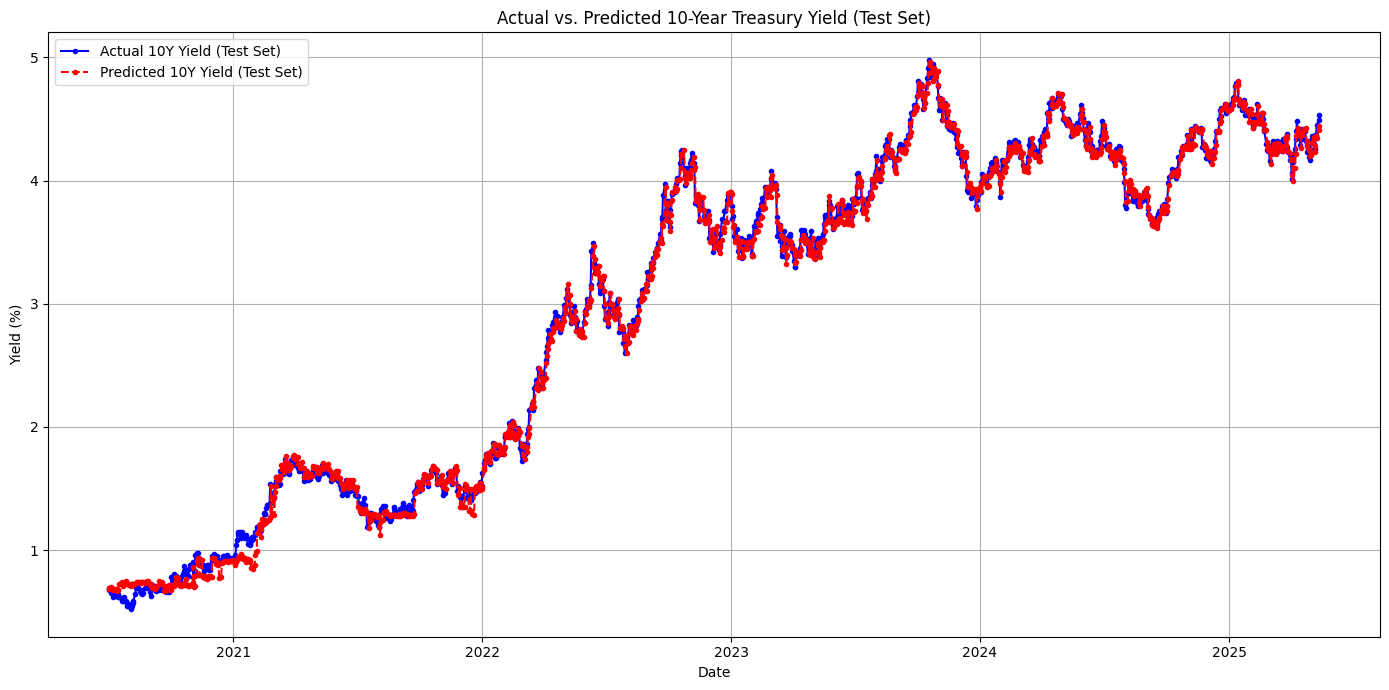


--- Hold-out Set Performance ---
RMSE: 0.0767
MAE: 0.0597
Directional Accuracy: 43.11%

Generating forecast for the next trading day...
Forecast for 2025-05-15:
Predicted 10Y Yield: 4.511%
Current 10Y Yield: 4.530%
Expected Change: -0.019% (down)

Updated performance report saved to 'performance_report_updated.txt'


In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import fredapi
from fredapi import Fred

# 1. Data Sourcing from FRED (Updated with API key)
def fetch_fred_data(api_key, start_date='2000-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """Fetch base yields and new economic data from FRED using API key."""
    # Initialize the FRED API client
    fred = Fred(api_key=api_key)
    
    series_map = {
        # Original Yields (DGS10 is base for target)
        'DGS3': '3_year_yield', 'DGS5': '5_year_yield', 'DGS7': '7_year_yield',
        'DGS10': '10_year_yield', 'DGS20': '20_year_yield',
        # New Yield for features
        'DGS2': '2_year_yield',
        # Original auxiliary series (if still needed)
        'VIXCLS': 'vix',
        # New Economic Series for Features
        'FEDFUNDS': 'fed_funds_rate',        # Federal Funds Rate
        'CPILFESL': 'core_cpi_yoy',         # Core CPI YoY (FRED series is already YoY % change)
        'WALCL': 'fed_total_assets_raw',   # Fed Total Assets (raw, for YoY calc)
        'GDP': 'gdp_raw',                  # Gross Domestic Product (raw, quarterly, for ratio)
        'DTWEXBGS': 'dollar_index'         # U.S. Dollar Index (Broad)
    }
    
    # Create empty DataFrame to store all series
    df = pd.DataFrame()
    
    # Fetch each series individually
    for series_id, col_name in series_map.items():
        try:
            print(f"Fetching {series_id} data...")
            series_data = fred.get_series(series_id, start_date, end_date)
            # Convert to DataFrame
            temp_df = pd.DataFrame(series_data, columns=[col_name])
            # Merge into main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')
        except Exception as e:
            print(f"Error fetching {series_id}: {e}")
    
    # Forward-fill to handle different frequencies and missing values from FRED
    df = df.ffill()
    return df

# 2. Feature Engineering (Revised and Extended)
def create_features(df, lags=5):
    """Generate lagged yields, term spreads, rolling metrics, and new economic features."""
    df_feat = df.copy()

    # Initial data cleaning: forward fill then backward fill to handle NaNs at edges
    df_feat = df_feat.ffill().bfill()

    # A. Lagged yield values (include 2-year yield)
    yield_cols_for_lags = ['3_year_yield', '5_year_yield', '7_year_yield',
                           '10_year_yield', '20_year_yield', '2_year_yield']
    for col in yield_cols_for_lags:
        if col in df_feat.columns:
            for lag in range(1, lags + 1):
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # B. Original Term spreads
    if '10_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_10y_3y'] = df_feat['10_year_yield'] - df_feat['3_year_yield']
    # (Add other original spreads if they were defined here, e.g., 20y-10y, 20y-3y)
    # Based on original code:
    if '20_year_yield' in df_feat.columns and '10_year_yield' in df_feat.columns:
        df_feat['spread_20y_10y'] = df_feat['20_year_yield'] - df_feat['10_year_yield']
    if '20_year_yield' in df_feat.columns and '3_year_yield' in df_feat.columns:
        df_feat['spread_20y_3y'] = df_feat['20_year_yield'] - df_feat['3_year_yield']


    # C. Original Rolling metrics for selected yields/spreads
    original_rolling_cols = []
    if '10_year_yield' in df_feat.columns: original_rolling_cols.append('10_year_yield')
    if 'spread_10y_3y' in df_feat.columns: original_rolling_cols.append('spread_10y_3y')
        
    for col in original_rolling_cols:
        df_feat[f'{col}_ma7'] = df_feat[col].rolling(window=7).mean()
        df_feat[f'{col}_ma30'] = df_feat[col].rolling(window=30).mean()
        df_feat[f'{col}_vol7'] = df_feat[col].rolling(window=7).std()
        df_feat[f'{col}_vol30'] = df_feat[col].rolling(window=30).std()

    # D. New Features Engineering
    # D1. 2Y–10Y spread and inversion flag
    if '10_year_yield' in df_feat.columns and '2_year_yield' in df_feat.columns:
        df_feat['spread_2y_10y'] = df_feat['10_year_yield'] - df_feat['2_year_yield']
        df_feat['inversion_flag_2y10y'] = (df_feat['spread_2y_10y'] < 0).astype(int)
    else: # Create placeholders if calculation fails to maintain column structure
        df_feat['spread_2y_10y'] = np.nan
        df_feat['inversion_flag_2y10y'] = 0


    # D2. Fed Total Assets YoY
    if 'fed_total_assets_raw' in df_feat.columns:
        df_feat['fed_total_assets_yoy'] = df_feat['fed_total_assets_raw'].pct_change(periods=252) # Approx 252 trading days/year
    else:
        df_feat['fed_total_assets_yoy'] = np.nan

    # D3. U.S. Federal Deficit as % of GDP - REMOVED

    # D4. Define list of primary economic series (levels) for further feature engineering
    # These are the 'level' features. Some are direct from fetch, some are calculated above.
    # Note: '2_year_yield' itself is used as the level for DGS2 features.
    # 'core_cpi_yoy' is already YoY from FRED.
    engineered_econ_series = {
        'fed_funds': 'fed_funds_rate',
        'core_cpi': 'core_cpi_yoy',
        'dgs2_level': '2_year_yield', # Using the original '2_year_yield' column as the level
        'fed_assets_yoy_level': 'fed_total_assets_yoy',
        'dollar_idx': 'dollar_index'
    }

    for prefix, series_name_in_df in engineered_econ_series.items():
        if series_name_in_df in df_feat.columns:
            series_data = df_feat[series_name_in_df]
            
            # Changes (diff)
            df_feat[f'{prefix}_chg1'] = series_data.diff(1)
            df_feat[f'{prefix}_chg5'] = series_data.diff(5)
            df_feat[f'{prefix}_chg20'] = series_data.diff(20)
            
            # Rolling mean
            df_feat[f'{prefix}_ma5'] = series_data.rolling(window=5).mean()
            df_feat[f'{prefix}_ma30'] = series_data.rolling(window=30).mean()
            
            # Rolling volatility (std)
            df_feat[f'{prefix}_vol5'] = series_data.rolling(window=5).std()
            df_feat[f'{prefix}_vol30'] = series_data.rolling(window=30).std()
        else:
            # Create NaN columns if source series is missing to prevent errors downstream
            # This helps if a FRED series fetch fails for some reason
            for suffix in ['_chg1', '_chg5', '_chg20', '_ma5', '_ma30', '_vol5', '_vol30']:
                df_feat[f'{prefix}{suffix}'] = np.nan
            print(f"Warning: Source series '{series_name_in_df}' for '{prefix}' features not found. NaN columns created.")

    # E. Clean up: Drop raw columns used only for intermediate calculations if desired
    # e.g., 'fed_total_assets_raw', 'gdp_raw'
    cols_to_drop_post_feat_eng = ['fed_total_assets_raw', 'gdp_raw']
    df_feat = df_feat.drop(columns=[col for col in cols_to_drop_post_feat_eng if col in df_feat.columns], errors='ignore')

    # F. Drop rows with any NaN values (critical after all feature engineering)
    df_feat = df_feat.dropna()
    
    return df_feat

# 3. Prepare Data for Modeling (Updated for 80/20 split and feature selection)
def prepare_data(df_features, target_col='10_year_yield', test_size_ratio=0.2):
    """Prepare features and target, then split into train/test sets (time-series aware)."""
    df_model_ready = df_features.copy()
    
    # Define the target variable: next day's 10-year yield
    df_model_ready['target'] = df_model_ready[target_col].shift(-1)
    
    # Drop the last row as it will have a NaN target due to shifting
    df_model_ready = df_model_ready.dropna(subset=['target'])
    
    # Define features (X) and target (y)
    # All columns in df_model_ready are potential features, except 'target' itself.
    # The original '10_year_yield' (current day's value) is kept as a feature.
    X = df_model_ready.drop(columns=['target'])
    y = df_model_ready['target']
    
    # Perform time-series split (80% train, 20% test)
    split_index = int(len(X) * (1 - test_size_ratio))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# 4. Model Training and Evaluation (Ensemble Model)
def train_evaluate_ensemble_model(X_train, y_train, X_test, y_test, target_series_name='10_year_yield'):
    """Train a VotingRegressor ensemble and evaluate its performance on the test set."""
    
    # Define base models
    # XGBoost: Using parameters from the original notebook's output if available, or good defaults.
    # Original output: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        subsample=0.8,
        random_state=42
    )
    
    # RandomForest: Using common default parameters.
    rf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )
    
    # Create the VotingRegressor ensemble with specified weights (0.8 XGB, 0.2 RF)
    ensemble_model = VotingRegressor(
        estimators=[('xgb', xgb_model), ('rf', rf_model)],
        weights=[0.8, 0.2]
    )
    
    print("\nTraining the ensemble model...")
    ensemble_model.fit(X_train, y_train)
    print("Ensemble model training complete.")
    
    # Make predictions on the test set
    print("\nEvaluating the model on the hold-out test set...")
    y_pred_test = ensemble_model.predict(X_test)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    # Directional Accuracy:
    # Compares sign(predicted_change) vs sign(actual_change)
    # Change is from actual_value_at_t to value_at_t+1
    # We need actual value at time t, which should be a feature in X_test.
    # The target_series_name ('10_year_yield') column in X_test is actual_value_at_t.
    
    directional_accuracy = np.nan # Default if calculation fails
    if target_series_name in X_test.columns:
        actual_value_t = X_test[target_series_name].loc[y_test.index]
        
        actual_change_sign = np.sign(y_test - actual_value_t)
        predicted_change_sign = np.sign(y_pred_test - actual_value_t) # y_pred_test is already a numpy array

        # Handle cases where change is zero (sign is 0)
        # If actual change is 0, prediction is correct if its change is also 0.
        directional_accuracy = np.mean(actual_change_sign == predicted_change_sign) * 100
    else:
        print(f"Warning: Column '{target_series_name}' not found in X_test for precise directional accuracy. Using y_test.shift().")
        # Fallback: compare change from y_test.shift(1) to y_test
        actual_diff_test = np.sign(y_test - y_test.shift(1).fillna(method='bfill'))
        # Ensure y_pred_test is a pandas Series for shift() if using this fallback with it
        y_pred_series_test = pd.Series(y_pred_test, index=y_test.index)
        pred_diff_test = np.sign(y_pred_series_test - y_test.shift(1).fillna(method='bfill'))
        directional_accuracy = np.mean(actual_diff_test == pred_diff_test) * 100
        

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'directional_accuracy': directional_accuracy
    }
    
    print(f"Test Set RMSE: {metrics['rmse']:.4f}")
    print(f"Test Set MAE: {metrics['mae']:.4f}")
    print(f"Test Set Directional Accuracy: {metrics['directional_accuracy']:.2f}%")
    
    # Plot predictions vs actuals for the test set
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual 10Y Yield (Test Set)', color='blue', marker='.', linestyle='-')
    plt.plot(y_test.index, y_pred_test, label='Predicted 10Y Yield (Test Set)', color='red', marker='.', linestyle='--')
    plt.title('Actual vs. Predicted 10-Year Treasury Yield (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('yield_predictions_ensemble_test_set.png')
    plt.show() # Uncomment to display plot in notebook
    plt.close()
    
    return ensemble_model, metrics

# Function to forecast the next day's yield
def forecast_next_day(model, df_features, target_col='10_year_yield'):
    """Forecast the next day's 10-year Treasury yield."""
    # Get the latest data point (most recent row)
    latest_data = df_features.iloc[-1:].copy()
    
    # Make prediction for the next day
    next_day_prediction = model.predict(latest_data)[0]
    
    # Calculate the change from current yield
    current_yield = latest_data[target_col].values[0]
    yield_change = next_day_prediction - current_yield
    direction = "up" if yield_change > 0 else "down" if yield_change < 0 else "unchanged"
    
    # Get the date of the forecast (next business day, simplified)
    forecast_date = latest_data.index[0] + pd.Timedelta(days=1)
    # If weekend, move to Monday
    if forecast_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
        forecast_date = forecast_date + pd.Timedelta(days=7 - forecast_date.weekday())
    
    forecast_info = {
        'date': forecast_date,
        'prediction': next_day_prediction,
        'current_yield': current_yield,
        'yield_change': yield_change,
        'direction': direction
    }
    
    return forecast_info

# Main Execution (Updated with API integration)
if __name__ == "__main__":
    # Your FRED API key (obtain from https://fred.stlouisfed.org/docs/api/api_key.html)
    fred_api_key = ""  # Replace with your actual API key
    
    # Fetch data using the API
    print("Fetching data from FRED API...")
    df_raw = fetch_fred_data(fred_api_key)
    
    # Create features
    # Ensure df_raw doesn't have all NaNs for a column needed, otherwise create_features might fail early
    df_raw_cleaned = df_raw.dropna(how='all', axis=1).ffill().bfill() # Basic clean before extensive feature engineering
    
    if df_raw_cleaned.empty or df_raw_cleaned['10_year_yield'].isnull().all():
        print("Critical error: Data fetching or initial cleaning resulted in unusable DataFrame.")
        # Exit or handle error appropriately
    else:
        print("Creating features...")
        df_features = create_features(df_raw_cleaned)
        
        if df_features.empty:
            print("Critical error: Feature engineering resulted in an empty DataFrame. Check NaNs and data availability.")
        else:
            # Prepare data (includes 80/20 split)
            print("Preparing data for modeling...")
            X_train, X_test, y_train, y_test = prepare_data(df_features, target_col='10_year_yield')
            if X_train.empty or X_test.empty:
                print("Critical error: Data preparation resulted in empty train or test set.")
            else:
                # Train and evaluate the ensemble model
                ensemble_model, test_metrics = train_evaluate_ensemble_model(X_train, y_train, X_test, y_test)
                
                print("\n--- Hold-out Set Performance ---")
                print(f"RMSE: {test_metrics['rmse']:.4f}")
                print(f"MAE: {test_metrics['mae']:.4f}")
                print(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%")
                
                # Forecast next day's yield
                print("\nGenerating forecast for the next trading day...")
                forecast = forecast_next_day(ensemble_model, df_features)
                forecast_date_str = forecast['date'].strftime('%Y-%m-%d')
                
                print(f"Forecast for {forecast_date_str}:")
                print(f"Predicted 10Y Yield: {forecast['prediction']:.3f}%")
                print(f"Current 10Y Yield: {forecast['current_yield']:.3f}%")
                print(f"Expected Change: {forecast['yield_change']:.3f}% ({forecast['direction']})")
                
                # Save performance report
                with open('performance_report_updated.txt', 'w') as f:
                    f.write("10-Year Treasury Yield Forecast Performance Report (Ensemble Model)\n")
                    f.write(f"Date: {datetime.today().strftime('%Y-%m-%d')}\n\n")
                    # Best parameters for ensemble components are fixed in this version.
                    f.write(f"XGBoost Params: lr=0.1, depth=5, n_est=200, subsample=0.8\n")
                    f.write(f"RandomForest Params: n_est=100\n")
                    f.write(f"Ensemble Weights: XGB(0.8), RF(0.2)\n\n")
                    f.write("--- Hold-out Set Performance ---\n")
                    f.write(f"RMSE: {test_metrics['rmse']:.4f}\n")
                    f.write(f"MAE: {test_metrics['mae']:.4f}\n")
                    f.write(f"Directional Accuracy: {test_metrics['directional_accuracy']:.2f}%\n\n")
                    f.write(f"Forecast for {forecast_date_str}:\n")
                    f.write(f"Predicted 10Y Yield: {forecast['prediction']:.3f}%\n")
                    f.write(f"Current 10Y Yield: {forecast['current_yield']:.3f}%\n")
                    f.write(f"Expected Change: {forecast['yield_change']:.3f}% ({forecast['direction']})\n\n")
                    f.write("Plots saved: yield_predictions_ensemble_test_set.png")
                print("\nUpdated performance report saved to 'performance_report_updated.txt'")